Link to the notebook: https://tinyurl.com/yedhb3ye
Copy the notebook to your GDrive to edit. (to update)

# Download prerequisite packages

First we will install extra packages which aren't included in the default colab environment. In this case, we are installing `gensim` for GloVe embeddings, `bpemb` for word-piece embeddings and tokenization, and some extra packages for tokenization.

In [1]:
!pip install bpemb
!pip install gensim
!python -m spacy download en_core_web_sm
import nltk
nltk.download('stopwords')

     |████████████████████████████████| 1.2 MB 4.1 MB/s 
     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Here we are just using some magic commands to make sure changes to external packages are automatically loaded and plots are displayed in the notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Ensuring reproducible results

Before we do anything else, we need to make sure that we seed all of the random number generators and set some flags to ensure that our results are reproducible across runs i.e. that we get the same result every time we run our code.

In [3]:
import torch
import random
import numpy as np

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

In [5]:
enforce_reproducibility()

# Representations in NLP

- We need some way to represent our text numerically when working with ML systems
- Transform our inuput text into a vector or a sequence of vectors depending on the method used 
- How to encode individual tokens?
- One way is to have a vocabulary of all possible tokens, assign each token a number, and encode them as a one-hot vector
![](https://raw.githubusercontent.com/copenlu/stat-nlp-book/master/img/sparse_binary.svg)
- Couple of problems
  - Inefficient: defines one feature for every word in the vocabulary
  - All words are orthogonal to each other, so what model learns about one word doesn't apply to similar words
- Solution: continuous word representations
  - Define each token in your vocab to be a $d$-dimensional vector
  - Train these vectors such that similar words have closer vectors (e.g. as measured by cosine distance)
    - Methods which do this are based on the "distributional hypothesis": similar words appear in similar contexts
    - E.g. word2vec trains word vectors to be able to predict the surrounding words (or vice-versa)
    - word2vec vectors: https://projector.tensorflow.org/
- Here we'll look at how to load/use two types of word embeddings: GloVe and byte-pair encoding (BPE) embeddings
  - GloVe is trained on word tokens using global word co-occurence statistics ([description here](https://nlp.stanford.edu/projects/glove/#:~:text=The%20training%20objective%20of%20GloVe,'%20probability%20of%20co%2Doccurrence.&text=For%20this%20reason%2C%20the%20resulting,examined%20in%20the%20word2vec%20package.))
  - BPE works by iteratively building a vocabulary of size N via merging the most frequent character n-grams from a large text corpus (e.g. Wikipedia). The resulting tokens aren't necessarily words, but are _word pieces_. As a result, you no longer have a problem where a given token doesn't appear in your vocabulary -- you can always deconstruct a word into one or more word pieces. The embeddings for these word pieces are trained using GloVe in the `bpemb` package. Read more [here](https://github.com/bheinzerling/bpemb) 

## GloVe embeddings

- For this we can use `gensim` which has a large variety of pre-trained word embeddings
- Check out their docs https://radimrehurek.com/gensim/auto_examples/index.html#documentation
- We first load 100-d embeddings trained on Wikipedia and the Gigaword corpus
- We can then examine what are the most similar words to some given words

In [6]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [7]:
# Load the vectors

glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [8]:
# Look at some of the most similar words
glove_vectors.most_similar('great')

[('greatest', 0.7882647514343262),
 ('good', 0.759279727935791),
 ('little', 0.7585746049880981),
 ('much', 0.7477047443389893),
 ('well', 0.7401014566421509),
 ('big', 0.7318841218948364),
 ('kind', 0.7308766841888428),
 ('important', 0.7286974191665649),
 ('there', 0.7225556373596191),
 ('way', 0.7116187214851379)]

In [9]:
# Get vector representation of word
glove_vectors['great']

array([-0.013786 ,  0.38216  ,  0.53236  ,  0.15261  , -0.29694  ,
       -0.20558  , -0.41846  , -0.58437  , -0.77355  , -0.87866  ,
       -0.37858  , -0.18516  , -0.128    , -0.20584  , -0.22925  ,
       -0.42599  ,  0.3725   ,  0.26077  , -1.0702   ,  0.62916  ,
       -0.091469 ,  0.70348  , -0.4973   , -0.77691  ,  0.66045  ,
        0.09465  , -0.44893  ,  0.018917 ,  0.33146  , -0.35022  ,
       -0.35789  ,  0.030313 ,  0.22253  , -0.23236  , -0.19719  ,
       -0.0053125, -0.25848  ,  0.58081  , -0.10705  , -0.17845  ,
       -0.16206  ,  0.087086 ,  0.63029  , -0.76649  ,  0.51619  ,
        0.14073  ,  1.019    , -0.43136  ,  0.46138  , -0.43585  ,
       -0.47568  ,  0.19226  ,  0.36065  ,  0.78987  ,  0.088945 ,
       -2.7814   , -0.15366  ,  0.01015  ,  1.1798   ,  0.15168  ,
       -0.050112 ,  1.2626   , -0.77527  ,  0.36031  ,  0.95761  ,
       -0.11385  ,  0.28035  , -0.02591  ,  0.31246  , -0.15424  ,
        0.3778   , -0.13599  ,  0.2946   , -0.31579  ,  0.4294

In [10]:
glove_vectors.most_similar('bad')

[('worse', 0.7929712533950806),
 ('good', 0.7702798247337341),
 ('things', 0.7653602361679077),
 ('too', 0.7630148530006409),
 ('thing', 0.7609667778015137),
 ('lot', 0.7443647384643555),
 ('kind', 0.740868091583252),
 ('because', 0.739879846572876),
 ('really', 0.7376541495323181),
 ("n't", 0.7336541414260864)]

## BPEmb embeddings

- Here we use `bpemb` which has pretrained BPE tokenizers/embeddings for 275 languages
- https://github.com/bheinzerling/bpemb
- First we load the English model with 25,000 word pieces and 100-dimensions
- The package has some similar functionality built in to `gensim`, for example observing the top similar words to a given word

In [11]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:01<00:00, 503082.19B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:02<00:00, 3893646.82B/s]


In [12]:
bpemb_en.most_similar('great')

[('little', 0.5838008522987366),
 ('▁great', 0.5713019371032715),
 ('grand', 0.4832311272621155),
 ('the', 0.47381392121315),
 ('▁glorious', 0.4674184322357178),
 ('bear', 0.4492991268634796),
 ('wh', 0.4481717348098755),
 ('mother', 0.44679754972457886),
 ('▁splend', 0.44266074895858765),
 ('southern', 0.427338182926178)]

In [13]:
bpemb_en['great']

array([ 0.188451, -0.271453, -0.28907 ,  0.061539, -0.00119 ,  0.023874,
       -0.067886, -0.331542,  0.216387,  0.357444, -0.37975 ,  0.568398,
        0.094106,  0.131808, -0.225529, -0.0577  , -0.471579,  0.270219,
        0.500174, -0.351869,  0.249958, -0.083147, -0.196093,  0.536826,
       -0.472552, -0.290486,  0.044731,  0.291949, -0.02748 ,  0.833167,
       -0.702959,  0.102262, -0.192826,  0.323853, -0.222146, -0.471987,
       -0.789   , -0.384075,  0.231821,  0.479966, -0.23674 , -0.233447,
       -0.095288,  0.994725,  0.38566 ,  0.539499, -0.117075, -0.424706,
       -0.35617 , -0.073661,  0.185955, -0.329411, -0.336546, -0.883611,
        0.450815, -0.087026,  0.547418, -0.177824, -0.50549 ,  0.423664,
        0.15182 ,  0.289324,  0.546515, -0.963773,  0.041765,  0.526582,
       -0.336767,  0.128516,  0.307212,  0.049208, -0.314852,  0.343516,
        0.09675 ,  0.033849, -0.260953,  0.340189, -0.114852,  0.128735,
        0.403689, -0.154596,  0.303449,  0.855851, 

In [14]:
bpemb_en.most_similar('bad')

[('▁bad', 0.7139850854873657),
 ('bir', 0.5771083831787109),
 ('her', 0.5590745806694031),
 ('hol', 0.5386293530464172),
 ('mad', 0.5319529175758362),
 ('wal', 0.5289992690086365),
 ('wolf', 0.5198653340339661),
 ('hal', 0.5146304368972778),
 ('▁luck', 0.5110129117965698),
 ('ün', 0.506809651851654)]

# Sentiment classification of movie reviews

We'll see how to train a basic logistic regression classifier for sentiment analysis. For this, we're using the [IMDB movie reviews dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).  

In [15]:
import spacy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [16]:
# Load the data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dev.csv to dev.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "dev.csv" with length 1318533 bytes
User uploaded file "test.csv" with length 1278536 bytes
User uploaded file "train.csv" with length 13328604 bytes


In [17]:
train_data = pd.read_csv('./train.csv').fillna('')
valid_data = pd.read_csv('./dev.csv').fillna('')
test_data = pd.read_csv('./test.csv').fillna('')
valid_data.head()

,review,label
0,Forever strong is one of those sports movies y...,positive
1,I saw this movie when Mystery Science Theater ...,positive
2,Like many others have commented before me here...,negative
3,Johnny Crawford is great in this movie of a tr...,positive
4,Another cult strikes again. This isn't a spoil...,negative


In [20]:
train_data.values[0]

array(["Well let me say that I have always been a Steven seagal fan and his movies are usually great but this just don't measure up to the rest. This in my opinion is very stupid I did not like it all. The biggest reason I don't like it is because it is very flawed and to me does not make much sense. The acting is very bad even Steven seagal does not do good acting, The rest of the actors I can see because they just do direct to video movies. It does not follow a straight storyline everything happens at once so that why it doesn't make much sense. Ther is barely any action in it at all and in order to make an action movie good you usually need action in it. The special effects are very bad and you can tell are fake. So all in all this has to seagals worst movie of all so if you want to see a Steven seagal movie don't rent this one just pretend it does not exist. So just avoid this movie.<br /><br />Overall score: ** out of ********** <br /><br />* out of *****",
       'negative'], dty

This defines some functions for vectorizing our text. For GloVe and BPE embeddings, this involves:

1. Tokenizing the text
2. Looking up the embedding for each token
3. Pooling the representations to obtain a single vector for the whole document

There are many options for pooling e.g. max-pooling, average-pooling, summation, etc.

In [18]:
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
labels = {'negative': 0, 'positive': 1}

def get_unigram_features(dataset, vectorizer):
  X = vectorizer.transform(dataset[:,0])
  y = [labels[l] for l in dataset[:,1]]
  return X,y

def get_bpemb_features(dataset, bpemb):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [bpemb.embed(x).mean(0) for x in tqdm(dataset[:,0])]
  y = [labels[l] for l in dataset[:,1]]
  return X,y
    
def get_glove_features(dataset, glove, nlp):
  X = []
  for x in tqdm(dataset[:,0]):
    # For glove embeddings, we first tokenize the sentence using spacy, lower-case and remove stopwords, and get the available word vectors
    vecs = np.vstack([glove[t.text.lower()] if t.text.lower() in glove else np.zeros(100) for t in nlp(x) if t.text.lower() not in stopwords])
    X.append(vecs.mean(0))
  y = [labels[l] for l in dataset[:,1]]
  return np.stack(X),y

This defines how to run a basic logistic regression classifier. Commented out are some code for if you want to run a hyperparameter search.

In [19]:
def run_classifier(X_train, y_train, X_test, y_test):
  # Define hyperparams for search
  # C = np.logspace(-6, 2, 50)
  # warm_start = [False, True]
  # class_weight = ['balanced', None]

  # hp = {"C": C, "warm_start": warm_start, 'class_weight': class_weight}

  classifier = LogisticRegression(penalty='l2', max_iter=1000)
  # classifier_random = RandomizedSearchCV(
  #     estimator=classifier,
  #     param_distributions=hp,
  #     n_iter=100,
  #     cv=5,
  #     verbose=2,
  #     random_state=1000,
  #     n_jobs=-1,
  #     scoring='f1'
  # )

  # classifier_random.fit(X_train, y_train)
  # print(classifier_random.best_params_)
  # print(classifier_random.best_score_)
  # model = classifier_random.best_estimator_
  classifier.fit(X_train,y_train)
  preds = classifier.predict(X_test)
  print(classification_report(y_test, preds))

First we'll run GloVe

In [ ]:
nlp = spacy.load('en_core_web_sm')
X_train,y_train = get_glove_features(train_data.values, glove_vectors, nlp)
X_test,y_test = get_glove_features(test_data.values, glove_vectors, nlp)
run_classifier(X_train, y_train, X_test, y_test)

100%|██████████| 1000/1000 [00:45<00:00, 22.06it/s]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       522
           1       0.78      0.79      0.78       478

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



Next BPE

In [ ]:
X_train,y_train = get_bpemb_features(train_data.values, bpemb_en)
X_test,y_test = get_bpemb_features(test_data.values, bpemb_en)
run_classifier(X_train, y_train, X_test, y_test)

100%|██████████| 1000/1000 [00:00<00:00, 1086.57it/s]


              precision    recall  f1-score   support

           0       0.76      0.78      0.77       522
           1       0.75      0.74      0.74       478

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



Just as a note, you can actually get much better performance using simple word counts -- why do you think this is?

In [ ]:
# Run on unigram features
vectorizer = CountVectorizer()
vectorizer.fit(train_data.values[:,0])
X_train,y_train = get_unigram_features(train_data.values, vectorizer)
X_test,y_test = get_unigram_features(test_data.values, vectorizer)
run_classifier(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       522
           1       0.86      0.86      0.86       478

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



# Sentiment analysis using a Bi-LSTM

# Reading data into a model

A simple and common way that data is read in PyTorch is to use the two following classes: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. 

The `Dataset` class can be extended to read in and store the data you are using for your experiment. The only requirements are to implement the `__len__` and `__getitem__` methods. `__len__` simply returns the size of your dataset and `__getitem__` takes an index and returns that sample from your dataset, processed in whatever way is necessary to be input to your model.

The `DataLoader` class determines how to iterate through your `Dataset`, including how to shuffle and batch your data.



In [ ]:
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

This is a utility function which, given a list of text samples and a tokenizer, will tokenize the text and return the IDs of the tokens in the vocabulary. The tokenizer will split the text into individual word-pieces and convert these to IDs in the tokenizer vocabulary. In addition, it will return the length of each sequence, which is needed when inputting padded data into an RNN in PyTorch.

In [ ]:
def text_to_batch_bilstm(text: List, tokenizer, max_len=512) -> Tuple[List, List]:
    """
    Creates a tokenized batch for input to a bilstm model
    :param text: A list of sentences to tokenize
    :param tokenizer: A tokenization function to use (i.e. fasttext)
    :return: Tokenized text as well as the length of the input sequence
    """
    # Some light preprocessing
    input_ids = [tokenizer.encode_ids_with_eos(t)[:max_len] for t in text]

    return input_ids, [len(ids) for ids in input_ids]

This is another utility function which defines how to combine data into a batch. Importantly, it determines the max length of a sequence in the batch and pads all of the samples with a `[PAD]` ID to this length.

In [ ]:
def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_data: The combined input_ids, seq_lens, and labels for the batch
    :return: A tuple of tensors (input_ids, seq_lens, labels)
    """
    input_ids = [i[0][0] for i in input_data]
    seq_lens = [i[1][0] for i in input_data]
    labels = [i[2] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    # Pad all of the input samples to the max length (25000 is the ID of the [PAD] token)
    input_ids = [(i + [25000] * (max_length - len(i))) for i in input_ids]

    # Make sure each sample is max_length long
    assert (all(len(i) == max_length for i in input_ids))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

This is the class which reads the dataset and processes indivudal samples. It is initialized with a pandas `DataFrame` and a tokenizer.

In [ ]:
# This will load the dataset and process it lazily in the __getitem__ function
class ClassificationDatasetReader(Dataset):
  def __init__(self, df, tokenizer):
    self.df = df
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.values[idx]
    # Calls the text_to_batch function
    input_ids,seq_lens = text_to_batch_bilstm([row[0]], self.tokenizer)
    label = labels[row[1]]
    return input_ids, seq_lens, label

Here we can test whether or not our implementation is correct. We first load english `bpemb` embeddings, which will be used to initialize the word embedding layer of our model, and the tokenizer which will be used in the dataset reader.

In [ ]:
# Extract the embeddings and add a randomly initialized embedding for our extra [PAD] token
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,100))], axis=0)
# Extract the vocab and add an extra [PAD] token
vocabulary = bpemb_en.emb.index2word + ['[PAD]']

In [ ]:
reader = ClassificationDatasetReader(valid_data, bpemb_en)
reader[0]

([[11685,
   1901,
   80,
   272,
   27,
   980,
   2611,
   6633,
   1220,
   280,
   3703,
   6060,
   24935,
   107,
   17935,
   18,
   352,
   4,
   4213,
   27,
   6629,
   7,
   17710,
   936,
   107,
   1364,
   4022,
   24934,
   6426,
   1274,
   24934,
   34,
   1025,
   6532,
   29,
   5223,
   168,
   24935,
   386,
   2320,
   107,
   114,
   4,
   361,
   24940,
   9291,
   37,
   34,
   260,
   1241,
   3419,
   14397,
   107,
   34,
   5219,
   2065,
   107,
   26,
   278,
   1186,
   121,
   3634,
   6633,
   24935,
   7,
   4520,
   80,
   954,
   26,
   7,
   2873,
   24935,
   1119,
   1102,
   107,
   80,
   1407,
   42,
   6629,
   7,
   17710,
   107,
   351,
   80,
   4538,
   1214,
   4294,
   592,
   215,
   2873,
   24935,
   386,
   3947,
   215,
   80,
   23585,
   9668,
   19199,
   34,
   505,
   4666,
   536,
   2967,
   24935,
   20510,
   1753,
   23585,
   822,
   1842,
   215,
   2873,
   34,
   107,
   80,
   5151,
   3285,
   1108,
   24935,
   38

# Creating the model

Next we will create a BiLSTM model with BPE word-piece embeddings. In this case we will extend the PyTorch class `torch.nn.Module`. To create your own module, you need only define your model architecture in the `__init__` function, and define how tensors are processed by your model in the `__forward__` function.

In [ ]:
from torch import nn

# Define a default lstm_dim
lstm_dim = 100

In [ ]:
# Define the model
class BiLSTMNetwork(nn.Module):
    """
    Basic BiLSTM network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                1,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'cls': nn.Linear(2*lstm_dim, n_classes)
        })
        self.n_classes = n_classes
        self.dropout = nn.Dropout(p=dropout_prob)

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['cls'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Max pool along the last dimension
        ff_in = self.dropout(torch.max(lstm_out, 1)[0])
        # Some magic to get the last output of the BiLSTM for classification (b x 2*lstm_dim)
        #ff_in = lstm_out.gather(1, input_lens.view(-1,1,1).expand(lstm_out.size(0), 1, lstm_out.size(2)) - 1).squeeze()

        # Get logits (b x n_classes)
        logits = self.model['cls'](ff_in).view(-1, self.n_classes)
        outputs = (logits,)
        if labels is not None:
            # Xentropy loss
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            outputs = (loss,) + outputs

        return outputs


## Choosing the device to run on

PyTorch tensors exist on a particular device: in order to use a GPU for example, the tensors in your network need to be moved to a GPU device. The following allows us to check if a GPU device is available and get a reference to that device which we can use to place tensors on it.

In [ ]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

Here we actually instantiate the model and move it to the GPU.

In [ ]:
# Create the model
model = BiLSTMNetwork(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=0.1, 
    n_classes=len(labels)
  ).to(device)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Training and evaluation

Here we define a metric which we are trying to improve -- in this case the accuracy of the model with respect to the label -- and functions to evaluate and train the model.

In [ ]:
def accuracy(logits, labels):
  logits = np.asarray(logits).reshape(-1, len(logits[0]))
  labels = np.asarray(labels).reshape(-1)
  return np.sum(np.argmax(logits, axis=-1) == labels).astype(np.float32) / float(labels.shape[0])

A useful utility which gives us a progress bar

In [ ]:
from tqdm import tqdm_notebook as tqdm

This is a utility function which will take a model and a validation dataloader and return the current accuracy of the model against that dataset. We can use this to know when to save the model and to perform early stopping if desired.

In [ ]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      _, logits = model(input_ids, seq_lens, labels=labels)
      labels_all.extend(list(labels.detach().cpu().numpy()))
      logits_all.extend(list(logits.detach().cpu().numpy()))
    acc = accuracy(logits_all, labels_all)

    return acc,labels_all,logits_all

Here we define the main training loop.

In [ ]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    patience: int = 10
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_acc = 0.0
  pcounter = 0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    acc,_,_ = evaluate(model, valid_dl)
    print(f'Validation accuracy: {acc}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if acc > best_acc:
      torch.save(model.state_dict(), 'best_model')
      best_acc = acc
      pcounter = 0
    else:
      pcounter += 1
      if pcounter == patience:
        break
        #gc.collect()

  model.load_state_dict(torch.load('best_model'))
  return model, losses

Now that we have the basic training and evaluation loops defined, we can create the datasets and optimizer and run it!

In [ ]:
from torch.optim import Adam

In [ ]:
# Define some hyperparameters
batch_size = 32
lr = 3e-4
n_epochs = 100

In [ ]:
# Create the dataset readers
train_dataset = ClassificationDatasetReader(train_data, bpemb_en)
# dataset loaded lazily with N workers in parallel
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)

valid_dataset = ClassificationDatasetReader(valid_data, bpemb_en)
valid_dl = DataLoader(valid_dataset, batch_size=len(valid_data), collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.706, train loss: 0.6291127808558674


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.775, train loss: 0.49497542070885436


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.817, train loss: 0.43726720782324147


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.807, train loss: 0.405570298623734


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.822, train loss: 0.3842741077700362


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.819, train loss: 0.35849207392134985


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.829, train loss: 0.3390820844771382


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.832, train loss: 0.32580356737866567


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.816, train loss: 0.31423775666057113


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.843, train loss: 0.29990804761933826


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.841, train loss: 0.28253054173704917


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.846, train loss: 0.2753956753986712


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.826, train loss: 0.26018185554125817


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.841, train loss: 0.252430533877196


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.839, train loss: 0.23731067148260415


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.837, train loss: 0.22418963613982398


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.843, train loss: 0.22149026511719053


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.85, train loss: 0.20855470722951827


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.85, train loss: 0.19294285706390207


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.844, train loss: 0.18020718901778182


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.854, train loss: 0.18175545565712567


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.852, train loss: 0.1824670918047809


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.852, train loss: 0.1651626218812534


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.858, train loss: 0.15584063616852029


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.849, train loss: 0.1432917040115157


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.855, train loss: 0.13085845418679068


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.843, train loss: 0.12233693568637005


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.848, train loss: 0.11811138791874194


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.841, train loss: 0.10424501107285579


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.849, train loss: 0.10340055050298619


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.828, train loss: 0.10076851759272547


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.846, train loss: 0.09121071907896965


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.844, train loss: 0.07568655497492693


  0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Validation accuracy: 0.828, train loss: 0.07842436553345035


Next we can plot the loss curve

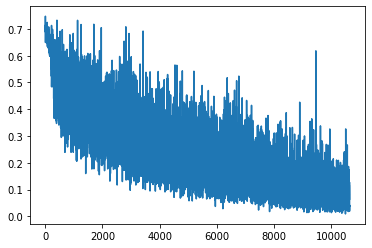

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
test_dataset = ClassificationDatasetReader(test_data, bpemb_en)
test_dl = DataLoader(test_dataset, batch_size=len(test_data), collate_fn=collate_batch_bilstm, num_workers=8)

val_acc,_,_ = evaluate(model, valid_dl)
test_acc,labs,logs = evaluate(model, test_dl)
print(f"Valiation accuracy: {val_acc}")
print(f"Test accuracy: {test_acc}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Valiation accuracy: 0.858
Test accuracy: 0.843


References 
- Introduction to Pytorch notebook from Stanford: https://nbviewer.jupyter.org/github/cgpotts/cs224u/blob/master/tutorial_pytorch.ipynb